# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_theme(style='darkgrid', context='talk')

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

import dill as pickle

/home/eduardo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Load the basic stats dataset

In [3]:
# Load the dataset
df = pd.read_csv('../saves/processed/nba_data.csv')
print(df.shape)
df.head()

(10749, 28)


,Season,H_win,FG%_V,3P%_V,2P%_V,FT%_V,ORB_V,DRB_V,TRB_V,AST_V,...,FT%_H,ORB_H,DRB_H,TRB_H,AST_H,STL_H,BLK_H,TOV_H,PF_H,PTS_H
0,2013,1,0.445,0.353,0.474,0.763,9.7,32.4,42.0,21.0,...,0.779,10.2,34.5,44.7,20.1,6.7,5.4,15.1,20.4,96.7
1,2013,1,0.432,0.348,0.456,0.779,11.4,32.7,44.1,22.7,...,0.760,7.6,29.2,36.9,22.5,8.9,4.5,14.8,19.5,102.2
2,2013,1,0.474,0.352,0.525,0.730,10.5,32.5,43.0,24.6,...,0.757,9.1,32.0,41.0,24.5,7.5,5.4,15.1,19.8,103.0
3,2013,1,0.459,0.369,0.497,0.753,8.8,29.4,38.1,20.9,...,0.751,12.1,32.1,44.1,21.2,7.1,3.7,14.2,20.0,98.2
4,2013,1,0.435,0.333,0.470,0.777,12.0,30.5,42.5,21.0,...,0.782,11.4,31.1,42.5,21.2,7.0,4.2,14.1,23.0,101.3


# Split and Scale the Dataset

## Change X and y in `train_test_split` to use original dataset or undersampled dataset

In [4]:
# Separate features and labels and split dataset
y = df['H_win']
X = df.drop(['H_win', 'Season'], axis=1)

# Summarize class distribution
#print(Counter(y))
# Define undersample strategy
#undersample = RandomUnderSampler(sampling_strategy='majority')
# Fit and apply the transform
#X_under, y_under = undersample.fit_resample(X, y)
# summarize class distribution
#print(Counter(y_under))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.25, random_state=42)

In [5]:
print(X_train.shape)
print(X_test.shape)

(8061, 26)
(2688, 26)


In [6]:
X_train.columns

Index(['FG%_V', '3P%_V', '2P%_V', 'FT%_V', 'ORB_V', 'DRB_V', 'TRB_V', 'AST_V',
       'STL_V', 'BLK_V', 'TOV_V', 'PF_V', 'PTS_V', 'FG%_H', '3P%_H', '2P%_H',
       'FT%_H', 'ORB_H', 'DRB_H', 'TRB_H', 'AST_H', 'STL_H', 'BLK_H', 'TOV_H',
       'PF_H', 'PTS_H'],
      dtype='object')

In [7]:
# Scaling
scaler = MinMaxScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
scaled_X_train.head()

,FG%_V,3P%_V,2P%_V,FT%_V,ORB_V,DRB_V,TRB_V,AST_V,STL_V,BLK_V,...,FT%_H,ORB_H,DRB_H,TRB_H,AST_H,STL_H,BLK_H,TOV_H,PF_H,PTS_H
0,0.610526,0.596154,0.642857,0.625731,0.428571,0.338462,0.500000,0.443548,0.488889,0.568627,...,0.532164,0.285714,0.300000,0.391892,0.500000,0.422222,0.549020,0.575758,0.475610,0.521277
1,0.715789,0.394231,0.920635,0.614035,0.242857,0.861538,0.864865,0.645161,0.444444,0.686275,...,0.450292,0.485714,0.492308,0.655405,0.467742,0.244444,0.333333,0.606061,0.597561,0.719858
2,0.326316,0.317308,0.246032,0.000000,0.700000,0.361538,0.635135,0.112903,0.333333,0.254902,...,0.152047,0.528571,0.192308,0.418919,0.338710,1.000000,0.549020,0.727273,0.634146,0.517730
3,0.389474,0.355769,0.428571,0.532164,0.828571,0.215385,0.567568,0.330645,0.777778,0.431373,...,0.514620,0.400000,0.461538,0.587838,0.338710,0.466667,0.431373,0.439394,0.207317,0.418440
4,0.284211,0.201923,0.166667,0.637427,0.628571,0.100000,0.378378,0.241935,0.355556,0.352941,...,0.245614,0.571429,0.153846,0.391892,0.306452,0.844444,0.313725,0.878788,0.719512,0.269504


In [8]:
# Scale the test data 
scaled_X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
scaled_X_test.head(3)

,FG%_V,3P%_V,2P%_V,FT%_V,ORB_V,DRB_V,TRB_V,AST_V,STL_V,BLK_V,...,FT%_H,ORB_H,DRB_H,TRB_H,AST_H,STL_H,BLK_H,TOV_H,PF_H,PTS_H
0,0.284211,0.201923,0.166667,0.637427,0.628571,0.100000,0.378378,0.241935,0.355556,0.352941,...,0.543860,0.428571,0.038462,0.229730,0.161290,0.488889,0.411765,0.287879,0.670732,0.237589
1,0.621053,0.355769,0.460317,0.766082,0.542857,0.138462,0.371622,0.459677,0.555556,0.411765,...,0.461988,0.257143,0.353846,0.425676,0.169355,0.266667,0.509804,0.378788,0.268293,0.312057
2,0.715789,0.490385,0.634921,0.695906,0.157143,0.376923,0.398649,0.637097,0.422222,0.549020,...,0.526316,0.457143,0.323077,0.493243,0.411290,0.311111,0.156863,0.818182,0.207317,0.531915


# Logistic Regression

In [9]:
# Train the model
lr = LogisticRegression()

# Fit data in the model
lr.fit(scaled_X_train, y_train)

LogisticRegression()

In [10]:
# Make predictions
y_pred = lr.predict(scaled_X_test)

In [11]:
# Check performance
print("LR model score: %.4f" % lr.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred))

LR model score: 0.6570
              precision    recall  f1-score   support

           0       0.63      0.50      0.56      1160
           1       0.67      0.77      0.72      1528

    accuracy                           0.66      2688
   macro avg       0.65      0.64      0.64      2688
weighted avg       0.65      0.66      0.65      2688



In [12]:
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(lr, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
print("Logistic Regression accuracy: %.3f (%.3f)" % (results.mean(), results.std()))

Logistic Regression accuracy: 0.650 (0.022)


In [324]:
# Optimization: define params_grid dictionary

# add different tolerance, not good practice to max out n of iterations
params_grid_lr = {
    'penalty': ['l1', 'l2'],
    'tol': [0.0001, 0.001, 0.01],
    'C': [1.0, 2, 3, 4, 5, 6],
    'solver': ['liblinear', 'saga']
}

In [325]:
# Define GridSearch 
gs_lr = GridSearchCV(estimator=lr, 
                      param_grid=params_grid_lr,
                      cv=2,
                      n_jobs=-1)

# Fit GridSearch to the data
gs_lr.fit(scaled_X_train, y_train)

/home/eduardo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/eduardo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/eduardo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/eduardo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy 

GridSearchCV(cv=2, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1.0, 2, 3, 4, 5, 6], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga'],
                         'tol': [0.0001, 0.001, 0.01]})

In [326]:
gs_lr.best_params_

{'C': 1.0, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.001}

In [327]:
# Store the best estimators
best_lr = gs_lr.best_estimator_

# Fit the data 
best_lr.fit(scaled_X_train, y_train)
y_pred_best_lr = best_lr.predict(scaled_X_test)

In [328]:
# Check performance
print("LR best model score: %.4f" % best_lr.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_best_lr))

LR best model score: 0.6570
              precision    recall  f1-score   support

           0       0.67      0.63      0.65      1164
           1       0.65      0.68      0.66      1139

    accuracy                           0.66      2303
   macro avg       0.66      0.66      0.66      2303
weighted avg       0.66      0.66      0.66      2303



In [329]:
# Check performance
best_lr.score(scaled_X_train, y_train)

0.6712031272621978

In [330]:
#results_lr = cross_val_score(best_lr, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
#print("Accuracy: %.3f (%.3f)" % (results_lr.mean(), results_lr.std()))

In [331]:
results_us_lr = cross_val_score(best_lr, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
print("Accuracy: %.3f (%.3f)" % (results_us_lr.mean(), results_us_lr.std()))

Accuracy: 0.649 (0.027)


# RandomForestClassifier

In [332]:
# Instantiate classifier
rfc = RandomForestClassifier()

# Fit the training data
rfc.fit(scaled_X_train, y_train)

# Make predictions
y_pred_rf = rfc.predict(scaled_X_test)

# Check the performance 
print('RFC model score: %.4f' % rfc.score(scaled_X_test, y_test))
print(classification_report(y_test, y_pred_rf))

RFC model score: 0.6057
              precision    recall  f1-score   support

           0       0.62      0.58      0.60      1164
           1       0.60      0.63      0.61      1139

    accuracy                           0.61      2303
   macro avg       0.61      0.61      0.61      2303
weighted avg       0.61      0.61      0.61      2303



In [333]:
# Create the random grid
params_grid_rfc = {'n_estimators': [100, 200, 500, 600],
               'max_features': ['log2', 'sqrt'],
               'max_depth': [3, 5, 7, 9],
               'min_samples_split': [10, 12, 15, 17],
               'min_samples_leaf': [1, 2, 4, 5]}

# Define GridSearch 
gs_rfc = GridSearchCV(estimator=rfc, 
                      param_grid=params_grid_rfc,
                      cv=2,
                      n_jobs=-1)

In [334]:
# Fit GridSearch to the data
gs_rfc.fit(scaled_X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4, 5],
                         'min_samples_split': [10, 12, 15, 17],
                         'n_estimators': [100, 200, 500, 600]})

In [335]:
gs_rfc.best_params_

{'max_depth': 5,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 500}

In [336]:
# Store best estimators
best_rfc = gs_rfc.best_estimator_

In [337]:
# Fit the data 
best_rfc.fit(scaled_X_train, y_train)
y_pred_best_rfc = best_rfc.predict(scaled_X_test)

In [338]:
# Check performance
print("RFC model score: %.3f" % best_rfc.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_best_rfc))

RFC model score: 0.644
              precision    recall  f1-score   support

           0       0.66      0.62      0.64      1164
           1       0.63      0.67      0.65      1139

    accuracy                           0.64      2303
   macro avg       0.64      0.64      0.64      2303
weighted avg       0.64      0.64      0.64      2303



In [339]:
# Check performance for trainset as well
best_rfc.score(scaled_X_train, y_train)

0.6875633415375706

In [340]:
#results_rfc = cross_val_score(best_rfc, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
#print("Accuracy: %.3f (%.3f)" % (results_rfc.mean(), results_rfc.std()))

In [341]:
results_us_rfc = cross_val_score(best_rfc, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
print("Accuracy: %.3f (%.3f)" % (results_us_rfc.mean(), results_us_rfc.std()))

Accuracy: 0.635 (0.030)


# SVM

In [342]:
# Instantiate SVM classifier
svc = SVC()

# Fit the data
svc.fit(scaled_X_train, y_train)

# Make predictions
y_pred_svc = svc.predict(scaled_X_test)

In [343]:
# Check performance
print("SVC model score: %.3f" % svc.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_svc))

SVC model score: 0.642
              precision    recall  f1-score   support

           0       0.65      0.63      0.64      1164
           1       0.63      0.65      0.64      1139

    accuracy                           0.64      2303
   macro avg       0.64      0.64      0.64      2303
weighted avg       0.64      0.64      0.64      2303



In [344]:
# Parameter grid for svc model
params_grid_svc = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.75, 1, 1.25, 2],
    'gamma': ['scale', 'auto']}

In [345]:
# Perform GridSearch for SVM
gs_svc = GridSearchCV(estimator=svc, 
                      param_grid=params_grid_svc,
                      cv=2,
                      n_jobs=-1)

In [346]:
# Fit GridSearch to the data
gs_svc.fit(scaled_X_train, y_train)

GridSearchCV(cv=2, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.75, 1, 1.25, 2], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']})

In [347]:
gs_svc.best_params_

{'C': 0.75, 'gamma': 'auto', 'kernel': 'rbf'}

In [348]:
# store best estimator
best_svc = gs_svc.best_estimator_

# Fit on the dataset 
best_svc.fit(scaled_X_train, y_train)
y_pred_best_svc = best_svc.predict(scaled_X_test)

In [349]:
# Check performance
print("SVC model score: %.3f" % best_svc.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_best_svc))

SVC model score: 0.654
              precision    recall  f1-score   support

           0       0.67      0.63      0.65      1164
           1       0.64      0.68      0.66      1139

    accuracy                           0.65      2303
   macro avg       0.65      0.65      0.65      2303
weighted avg       0.65      0.65      0.65      2303



In [350]:
best_svc.score(scaled_X_train, y_train)

0.6664253655711597

In [266]:
#results_svc = cross_val_score(best_svc, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
#print("Accuracy: %.3f (%.3f)" % (results_svc.mean(), results_svc.std()))

Accuracy: 0.659 (0.015)


In [351]:
results_us_svc = cross_val_score(best_svc, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
print("Accuracy: %.3f (%.3f)" % (results_us_svc.mean(), results_us_svc.std()))

Accuracy: 0.647 (0.027)


# Naive Bayes

In [352]:
# Instantiate NB classifier
gnb = GaussianNB()

# Fit the data
gnb.fit(scaled_X_train, y_train)

# Predictions
y_pred_gnb = gnb.predict(scaled_X_test)

In [353]:
# Check performance
print("Naive Bayes model score: %.3f" % gnb.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_gnb))

Naive Bayes model score: 0.641
              precision    recall  f1-score   support

           0       0.65      0.62      0.63      1164
           1       0.63      0.66      0.65      1139

    accuracy                           0.64      2303
   macro avg       0.64      0.64      0.64      2303
weighted avg       0.64      0.64      0.64      2303



In [354]:
# Params grid for GaussianNB
params_grid_gnb = {'var_smoothing': [1e-10, 5e-10, 1e-9, 5e-8]}

In [355]:
# Perform GridSearch for NB
gs_gnb = GridSearchCV(estimator=gnb, 
                      param_grid=params_grid_gnb,
                      cv=2,
                      n_jobs=-1)

# Fit GridSearch to the data
gs_gnb.fit(scaled_X_train, y_train)

GridSearchCV(cv=2, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-10, 5e-10, 1e-09, 5e-08]})

In [356]:
gs_gnb.best_params_

{'var_smoothing': 1e-10}

In [357]:
# store best estimator
best_gnb = gs_gnb.best_estimator_

# Fit on the dataset 
best_gnb.fit(scaled_X_train, y_train)
y_pred_best_gnb = best_gnb.predict(scaled_X_test)

In [358]:
# Check performance
print("Naive Bayes best model score: %.3f" % best_gnb.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_best_gnb))

Naive Bayes best model score: 0.641
              precision    recall  f1-score   support

           0       0.65      0.62      0.63      1164
           1       0.63      0.66      0.65      1139

    accuracy                           0.64      2303
   macro avg       0.64      0.64      0.64      2303
weighted avg       0.64      0.64      0.64      2303



In [359]:
#results_gnb = cross_val_score(best_gnb, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
#print("Accuracy: %.3f (%.3f)" % (results_gnb.mean(), results_gnb.std()))

In [360]:
results_us_gnb = cross_val_score(best_gnb, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
print("Accuracy: %.3f (%.3f)" % (results_us_gnb.mean(), results_us_gnb.std()))

Accuracy: 0.632 (0.033)


# XGBoost Classifier

In [361]:
# Instantiate XGBClassifier
xgb = XGBClassifier(use_label_encoder=False)

# Fit the data
xgb.fit(scaled_X_train, y_train)

/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:22] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [362]:
# Make predictions
y_pred_xgb = xgb.predict(scaled_X_test)

In [363]:
# Check performance
print("XGB model score: %.3f" % xgb.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_xgb))

XGB model score: 0.606
              precision    recall  f1-score   support

           0       0.62      0.59      0.60      1164
           1       0.60      0.62      0.61      1139

    accuracy                           0.61      2303
   macro avg       0.61      0.61      0.61      2303
weighted avg       0.61      0.61      0.61      2303



In [364]:
# Create parameters dictionary
params_grid_xgb = {
    'max_depth': [3, 4, 5],
    'n_estimators': [80, 90, 100, 110],
    'subsample': [0.75, 1],
    'colsample_bytree': [1] 
}

In [365]:
gs_xgb = GridSearchCV(estimator=xgb,
                     param_grid=params_grid_xgb,
                     cv=2,
                     verbose=1)

gs_xgb.fit(scaled_X_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[23:06:27] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and wil

[23:06:28] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:28] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:28] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:28] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:28] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:28] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:28] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:28] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:28] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:28] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:29] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:29] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:29] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:29] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:29] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:29] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:29] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:29] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:29] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:30] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:30] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:30] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:30] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:30] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:30] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:30] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:30] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:30] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:31] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:31] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:31] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:31] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:31] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:31] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:31] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:31] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:31] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:32] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:32] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:32] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:32] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:32] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:32] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:32] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:33] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:06:33] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:33] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:33] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=12,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact',
                                     use_label_encoder=False,
                                     validate_parameters=1, verbosity=None),
             param_grid={'colsample_bytree': [1], 'max_depth': [3, 4, 5],
                         'n_estimators': [80, 90, 100, 110],
                         'subsample': [0.75, 1]},
             verbose=1)

In [366]:
gs_xgb.best_params_

{'colsample_bytree': 1, 'max_depth': 3, 'n_estimators': 80, 'subsample': 1}

In [367]:
# Store best estimator combination
best_xgb = gs_xgb.best_estimator_

# Fit on the dataset 
best_xgb.fit(scaled_X_train, y_train)
y_pred_best_xgb = best_xgb.predict(scaled_X_test)

[23:06:35] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [368]:
# Check performance
print("XGB best model score: %.3f" % best_xgb.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_best_xgb))

XGB best model score: 0.629
              precision    recall  f1-score   support

           0       0.64      0.60      0.62      1164
           1       0.62      0.65      0.64      1139

    accuracy                           0.63      2303
   macro avg       0.63      0.63      0.63      2303
weighted avg       0.63      0.63      0.63      2303



In [369]:
#results_xgb = cross_val_score(best_xgb, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
#print("Accuracy: %.3f (%.3f)" % (results_xgb.mean(), results_xgb.std()))

In [370]:
results_us_xgb = cross_val_score(best_xgb, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
print("Accuracy: %.3f (%.3f)" % (results_us_xgb.mean(), results_us_xgb.std()))

/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and wil

[23:06:43] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:43] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:43] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:43] WARNING: /tmp/abs_40obctay9q/croots/recip

/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and wil

[23:06:43] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:43] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:43] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:44] WARNING: /tmp/abs_40obctay9q/croots/recip

/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [61]:
means = [results_lr.mean(), results_rfc.mean(), results_svc.mean(), results_gnb.mean(), results_xgb.mean()]
std = [results_lr.std(), results_rfc.std(), results_svc.std(), results_gnb.std(), results_xgb.std()]

In [371]:
means_us = [results_us_lr.mean(), results_us_rfc.mean(), results_us_svc.mean(), results_us_gnb.mean(), results_us_xgb.mean()]
std_us = [results_us_lr.std(), results_us_rfc.std(), results_us_svc.std(), results_us_gnb.std(), results_us_xgb.std()]

# Load adv stats dataset

In [13]:
data = pd.read_csv('../saves/processed/nba_adv_data.csv')
print(data.shape)
data.head()

(10749, 16)


,Season,H_win,ORtg_V,DRtg_V,TS_V,TOV_V,ORB_V,DRB_V,Wp100_V,ORtg_H,DRtg_H,TS_H,TOV_H,ORB_H,DRB_H,Wp100_H
0,2013,1,101.7,107.4,0.525,13.9,22.4,75.5,0.280488,104.1,99.3,0.535,14.3,24.9,76.8,0.682927
1,2013,1,102.5,100.5,0.518,14.2,27.2,75.4,0.585366,110.9,105.8,0.590,14.6,20.6,73.0,0.658537
2,2013,1,112.1,104.8,0.567,12.7,25.0,72.5,0.695122,104.2,110.6,0.542,13.7,20.2,71.0,0.329268
3,2013,1,106.7,107.7,0.555,14.1,21.7,72.3,0.536585,104.2,107.7,0.518,13.0,27.2,75.8,0.402439
4,2013,1,102.9,107.7,0.517,14.2,27.4,74.2,0.304878,108.8,105.3,0.545,13.2,27.2,74.9,0.585366


## Make sure to change X and y in `train_test_split` to use either original dataset or undersampled dataset

In [14]:
# Separate label and features, split dataset
y = data['H_win']
X = data.drop(['Season', 'Wp100_V', 'Wp100_H', 'H_win'], axis=1)

#print(Counter(y))
#undersample = RandomUnderSampler(sampling_strategy='majority')
#X_under, y_under = undersample.fit_resample(X, y)
#print(Counter(y_under))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = MinMaxScaler()
scaler.fit(X_train)
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [15]:
print(X_train.shape)
print(X_test.shape)

(7524, 12)
(3225, 12)


In [16]:
print(scaled_X_test.columns)
scaled_X_test.head(3)

Index(['ORtg_V', 'DRtg_V', 'TS_V', 'TOV_V', 'ORB_V', 'DRB_V', 'ORtg_H',
       'DRtg_H', 'TS_H', 'TOV_H', 'ORB_H', 'DRB_H'],
      dtype='object')


,ORtg_V,DRtg_V,TS_V,TOV_V,ORB_V,DRB_V,ORtg_H,DRtg_H,TS_H,TOV_H,ORB_H,DRB_H
0,0.324561,0.467742,0.198276,0.704918,0.703704,0.301887,0.561404,0.543011,0.405172,0.426230,0.533333,0.311321
1,0.671053,0.698925,0.525862,0.491803,0.688889,0.462264,0.618421,0.338710,0.594828,0.540984,0.392593,0.745283
2,0.635965,0.483871,0.612069,0.344262,0.155556,0.537736,0.526316,0.881720,0.508621,0.770492,0.496296,0.603774


# Logistic regression

In [17]:
lr = LogisticRegression()

# Fit the data 
lr.fit(scaled_X_train, y_train)

# Make predictions
y_pred = lr.predict(scaled_X_test)

In [18]:
# Check performance
print("LR model score: %.4f" % lr.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred))

LR model score: 0.6682
              precision    recall  f1-score   support

           0       0.64      0.54      0.58      1404
           1       0.68      0.77      0.72      1821

    accuracy                           0.67      3225
   macro avg       0.66      0.65      0.65      3225
weighted avg       0.67      0.67      0.66      3225



In [19]:
params_grid_lr = {
    'penalty': ['l1', 'l2'],
    'tol': [0.0005, 0.001, 0.005, 0.01],
    'C': [1.0, 2, 3, 4, 5, 6],
    'solver': ['liblinear', 'saga']}

gs_lr = GridSearchCV(estimator=lr, 
                      param_grid=params_grid_lr,
                      cv=2,
                      n_jobs=-1).fit(scaled_X_train, y_train)

/home/eduardo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/eduardo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/eduardo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/eduardo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy 

In [20]:
gs_lr.best_params_

{'C': 2, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0005}

In [21]:
best_lr = gs_lr.best_estimator_

# Make fit the data
best_lr.fit(scaled_X_train, y_train)

# Make pred
y_pred_best_lr = best_lr.predict(scaled_X_test)

In [22]:
# Check performance
print("LR best model score: %.4f" % best_lr.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_best_lr))

LR best model score: 0.6685
              precision    recall  f1-score   support

           0       0.64      0.54      0.59      1404
           1       0.68      0.77      0.72      1821

    accuracy                           0.67      3225
   macro avg       0.66      0.65      0.65      3225
weighted avg       0.67      0.67      0.66      3225



In [23]:
results_lr_adv = cross_val_score(best_lr, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
print("Accuracy: %.3f (%.3f)" % (results_lr_adv.mean(), results_lr_adv.std()))

Accuracy: 0.674 (0.026)


In [24]:
#results_us_lr_adv = cross_val_score(best_lr, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
#print("Accuracy: %.3f (%.3f)" % (results_us_lr_adv.mean(), results_us_lr_adv.std()))

# RandomForest Classifier

In [25]:
# Instantiate classifier
rfc = RandomForestClassifier()

# Fit the training data
rfc.fit(scaled_X_train, y_train)

# Make predictions
y_pred_rf = rfc.predict(scaled_X_test)

# Check the performance 
print('RFC model score: %.4f' % rfc.score(scaled_X_test, y_test))
print(classification_report(y_test, y_pred_rf))

RFC model score: 0.6217
              precision    recall  f1-score   support

           0       0.57      0.51      0.54      1404
           1       0.65      0.71      0.68      1821

    accuracy                           0.62      3225
   macro avg       0.61      0.61      0.61      3225
weighted avg       0.62      0.62      0.62      3225



In [26]:
# Create the random grid
params_grid_rfc = {'n_estimators': [80, 90, 100, 110],
               'max_features': ['log2', 'sqrt'],
               'max_depth': [3, 5, 7, 9],
               'min_samples_split': [10, 12, 15, 17],
               'min_samples_leaf': [4, 5, 6, 7]}

# Define GridSearch 
gs_rfc = GridSearchCV(estimator=rfc, 
                      param_grid=params_grid_rfc,
                      cv=2,
                      n_jobs=-1)

In [27]:
# Fit GridSearch to the data
gs_rfc.fit(scaled_X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [4, 5, 6, 7],
                         'min_samples_split': [10, 12, 15, 17],
                         'n_estimators': [80, 90, 100, 110]})

In [28]:
gs_rfc.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 6,
 'min_samples_split': 12,
 'n_estimators': 110}

In [29]:
# Store best estimators
best_rfc = gs_rfc.best_estimator_

# Fit the data 
best_rfc.fit(scaled_X_train, y_train)
y_pred_best_rfc = best_rfc.predict(scaled_X_test)

# Check performance
print("RFC model score: %.4f" % best_rfc.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_best_rfc))

RFC model score: 0.6598
              precision    recall  f1-score   support

           0       0.65      0.48      0.55      1404
           1       0.67      0.80      0.73      1821

    accuracy                           0.66      3225
   macro avg       0.66      0.64      0.64      3225
weighted avg       0.66      0.66      0.65      3225



In [30]:
results_rfc_adv = cross_val_score(best_rfc, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
print("Accuracy: %.3f (%.3f)" % (results_rfc_adv.mean(), results_rfc_adv.std()))

Accuracy: 0.660 (0.023)


In [31]:
#results_us_rfc_adv = cross_val_score(best_rfc, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
#print("Accuracy: %.3f (%.3f)" % (results_us_rfc_adv.mean(), results_us_rfc_adv.std()))

In [196]:
# Get importance
#importance = best_rfc.feature_importances_
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i, v))
# plot feature importance
#plt.bar([x for x in range(len(importance))], importance)
#plt.show()

# SVM

In [32]:
# Instantiate SVM classifier
svc = SVC()

# Fit the data
svc.fit(scaled_X_train, y_train)

# Make predictions
y_pred_svc = svc.predict(scaled_X_test)

# Check performance
print("SVC model score: %.3f" % svc.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_svc))

SVC model score: 0.665
              precision    recall  f1-score   support

           0       0.65      0.50      0.57      1404
           1       0.67      0.79      0.73      1821

    accuracy                           0.66      3225
   macro avg       0.66      0.65      0.65      3225
weighted avg       0.66      0.66      0.66      3225



In [33]:
# Parameter grid for svc model
params_grid_svc = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.5, 0.6, 0.75, 1, 1.25],
    'gamma': ['scale', 'auto']}

In [34]:
# Perform GridSearch for SVM
gs_svc = GridSearchCV(estimator=svc, 
                      param_grid=params_grid_svc,
                      cv=2,
                      n_jobs=-1).fit(scaled_X_train, y_train)

gs_svc.best_params_

{'C': 0.6, 'gamma': 'scale', 'kernel': 'linear'}

In [42]:
# store best estimator
best_svc = gs_svc.best_estimator_

# Fit on the dataset 
best_svc.fit(scaled_X_train, y_train)
y_pred_best_svc = best_svc.predict(scaled_X_test)

# Check performance
print("SVC model score: %.3f" % best_svc.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_best_svc))

SVC model score: 0.671
              precision    recall  f1-score   support

           0       0.65      0.53      0.59      1404
           1       0.68      0.78      0.73      1821

    accuracy                           0.67      3225
   macro avg       0.67      0.66      0.66      3225
weighted avg       0.67      0.67      0.67      3225



In [43]:
results_svc_adv = cross_val_score(best_svc, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
print("Accuracy: %.3f (%.3f)" % (results_svc_adv.mean(), results_svc_adv.std()))

Accuracy: 0.672 (0.026)


In [297]:
#results_us_svc_adv = cross_val_score(best_svc, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
#print("Accuracy: %.3f (%.3f)" % (results_us_svc_adv.mean(), results_us_svc_adv.std()))

# Naive Bayes

In [44]:
# Instantiate NB classifier
gnb = GaussianNB()

# Fit the data
gnb.fit(scaled_X_train, y_train)

# Predictions
y_pred_gnb = gnb.predict(scaled_X_test)

# Check performance
print("Naive Bayes model score: %.3f" % gnb.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_gnb))

Naive Bayes model score: 0.663
              precision    recall  f1-score   support

           0       0.63      0.56      0.59      1404
           1       0.69      0.74      0.71      1821

    accuracy                           0.66      3225
   macro avg       0.66      0.65      0.65      3225
weighted avg       0.66      0.66      0.66      3225



In [45]:
# Params grid for GaussianNB
params_grid_gnb = {'var_smoothing': [1e-10, 5e-10, 1e-9, 5e-9]}

# Perform GridSearch for NB
gs_gnb = GridSearchCV(estimator=gnb, 
                      param_grid=params_grid_gnb,
                      cv=2,
                      n_jobs=-1)

# Fit GridSearch to the data
gs_gnb.fit(scaled_X_train, y_train)
gs_gnb.best_params_

{'var_smoothing': 1e-10}

In [46]:
# store best estimator
best_gnb = gs_gnb.best_estimator_

# Fit on the dataset 
best_gnb.fit(scaled_X_train, y_train)
y_pred_best_gnb = best_gnb.predict(scaled_X_test)

# Check performance
print("Naive Bayes best model score: %.3f" % best_gnb.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_best_gnb))

Naive Bayes best model score: 0.663
              precision    recall  f1-score   support

           0       0.63      0.56      0.59      1404
           1       0.69      0.74      0.71      1821

    accuracy                           0.66      3225
   macro avg       0.66      0.65      0.65      3225
weighted avg       0.66      0.66      0.66      3225



In [49]:
results_gnb_adv = cross_val_score(best_gnb, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
print("Accuracy: %.3f (%.3f)" % (results_gnb_adv.mean(), results_gnb_adv.std()))

Accuracy: 0.666 (0.024)


In [48]:
#results_us_gnb_adv = cross_val_score(best_gnb, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
#print("Accuracy: %.3f (%.3f)" % (results_us_gnb_adv.mean(), results_us_gnb_adv.std()))

# XGBoost

In [50]:
# Instantiate XGBClassifier
xgb = XGBClassifier(use_label_encoder=False)

# Fit the data
xgb.fit(scaled_X_train, y_train)

# Make predictions
y_pred_xgb = xgb.predict(scaled_X_test)

# Check performance
print("XGB model score: %.3f" % xgb.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_xgb))

/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:17:57] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB model score: 0.628
              precision    recall  f1-score   support

           0       0.58      0.53      0.55      1404
           1       0.66      0.71      0.68      1821

    accuracy                           0.63      3225
   macro avg       0.62      0.62      0.62      3225
weighted avg       0.63      0.63      0.63      3225



In [51]:
params_dist_xgb = {
    'max_depth': [3, 4, 5],
    'n_estimators': [80, 90, 100, 110],
    'subsample': [0.75, 1],
    #'colsample_bytree': [1]
}

In [52]:
rs_xgb = RandomizedSearchCV(estimator=xgb,
                     param_distributions=params_dist_xgb,
                     cv=10,
                     verbose=1)

# Perform the gridsearch
rs_xgb.fit(scaled_X_train, y_train)
rs_xgb.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[10:18:01] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:01] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and wil

[10:18:01] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:01] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:01] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:01] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:02] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:02] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:02] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:02] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:02] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:02] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:02] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:02] WARNING: /tmp/abs_40obctay9q/croots/recip

/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:03] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:03] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:03] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:03] WARNING: /tmp/abs_40obctay9q/croots/recip

/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:03] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:03] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:03] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and wil

[10:18:03] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:03] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:03] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:04] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:04] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:04] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:04] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:04] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:04] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:04] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:05] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:05] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:05] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:05] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:05] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:05] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:05] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:05] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:06] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:06] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:06] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:06] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:06] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:06] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:06] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:07] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:07] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:07] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:07] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:07] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:08] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:08] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:08] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:08] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:08] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:08] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:08] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:08] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:08] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:08] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:08] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:09] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:09] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:09] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:09] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:09] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:09] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:09] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:09] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:09] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:10] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:10] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:10] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:10] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:10] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:10] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:10] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:10] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:11] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:11] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:11] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:11] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:11] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:11] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:11] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:11] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:11] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:11] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:12] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:12] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:12] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:12] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:12] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:12] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:12] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:18:12] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:12] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:12] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:13] WARNING: /tmp/abs_40obctay9q/croots/recip

/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


{'subsample': 1, 'n_estimators': 80, 'max_depth': 3}

In [53]:
# store best estimator
best_xgb = rs_xgb.best_estimator_

# Fit on the dataset 
best_xgb.fit(scaled_X_train, y_train)
y_pred_best_xgb = best_xgb.predict(scaled_X_test)

# Check performance
print("XGBClassifier best model score: %.3f" % best_xgb.score(scaled_X_test, y_test))
print(classification_report(y_test, y_pred_best_xgb))

[10:18:15] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier best model score: 0.664
              precision    recall  f1-score   support

           0       0.63      0.56      0.59      1404
           1       0.69      0.74      0.71      1821

    accuracy                           0.66      3225
   macro avg       0.66      0.65      0.65      3225
weighted avg       0.66      0.66      0.66      3225



In [54]:
results_xgb_adv = cross_val_score(best_xgb, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
print("Accuracy: %.3f (%.3f)" % (results_xgb_adv.mean(), results_xgb_adv.std()))

/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and wil

[10:18:25] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:25] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:25] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:25] WARNING: /tmp/abs_40obctay9q/croots/recip

/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and wil

[10:18:25] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:25] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:25] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:25] WARNING: /tmp/abs_40obctay9q/croots/recip

In [55]:
#results_us_xgb_adv = cross_val_score(best_xgb, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
#print("Accuracy: %.3f (%.3f)" % (results_us_xgb_adv.mean(), results_us_xgb_adv.std()))

In [215]:
# get importance
#importance = best_xgb.feature_importances_
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#plt.bar([x for x in range(len(importance))], importance)
#plt.show()

In [56]:
means_adv = [results_lr_adv.mean(), results_rfc_adv.mean(), 
    results_svc_adv.mean(), results_gnb_adv.mean(), results_xgb_adv.mean()]

std_adv = [results_lr_adv.std(), results_rfc_adv.std(), 
    results_svc_adv.std(), results_gnb_adv.std(), results_xgb_adv.std()]

In [216]:
#means_us_adv = [results_us_lr_adv.mean(), results_us_rfc_adv.mean(), 
#    results_us_svc_adv.mean(), results_us_gnb_adv.mean(), results_us_xgb_adv.mean()]

#std_us_adv = [results_us_lr_adv.std(), results_us_rfc_adv.std(), 
#    results_us_svc_adv.std(), results_us_gnb_adv.std(), results_us_xgb_adv.std()]

# Reflecting about the results

In [372]:
results_us_df = pd.DataFrame({'Accuracy': means_us,
                           'STD': std_us}, 
                          index=['Log. Reg.', 'RandomForest', 'SVM', 'Naive Bayes', 'XGBClassifier'])
results_us_df

,Accuracy,STD
Log. Reg.,0.648733,0.026689
RandomForest,0.635268,0.030212
SVM,0.647440,0.027211
Naive Bayes,0.631820,0.032934
XGBClassifier,0.611378,0.030902


In [218]:
results_us_adv_df = pd.DataFrame({'Accuracy': means_us_adv,
                               'STD': std_us_adv}, 
                              index=['Log. Reg.', 'RandomForest', 'SVM', 'Naive Bayes', 'XGBClassifier'])
results_us_adv_df

,Accuracy,STD
Log. Reg.,0.653640,0.014226
RandomForest,0.643533,0.024910
SVM,0.651827,0.016168
Naive Bayes,0.647510,0.020356
XGBClassifier,0.623633,0.031853


In [123]:
results_df = pd.DataFrame({'Accuracy': means,
                           'STD': std}, 
                          index=['Log. Reg.', 'RandomForest', 'SVM', 'Naive Bayes', 'XGBClassifier'])
results_df

,Accuracy,STD
Log. Reg.,0.655120,0.016348
RandomForest,0.650669,0.023576
SVM,0.659217,0.014717
Naive Bayes,0.633926,0.019461
XGBClassifier,0.625004,0.030939


In [57]:
results_adv_df = pd.DataFrame({'Accuracy': means_adv,
                               'STD': std_adv}, 
                              index=['Log. Reg.', 'RandomForest', 'SVM', 'Naive Bayes', 'XGBClassifier'])
results_adv_df

,Accuracy,STD
Log. Reg.,0.673823,0.026197
RandomForest,0.660176,0.022525
SVM,0.671652,0.026041
Naive Bayes,0.665754,0.024267
XGBClassifier,0.651175,0.017638


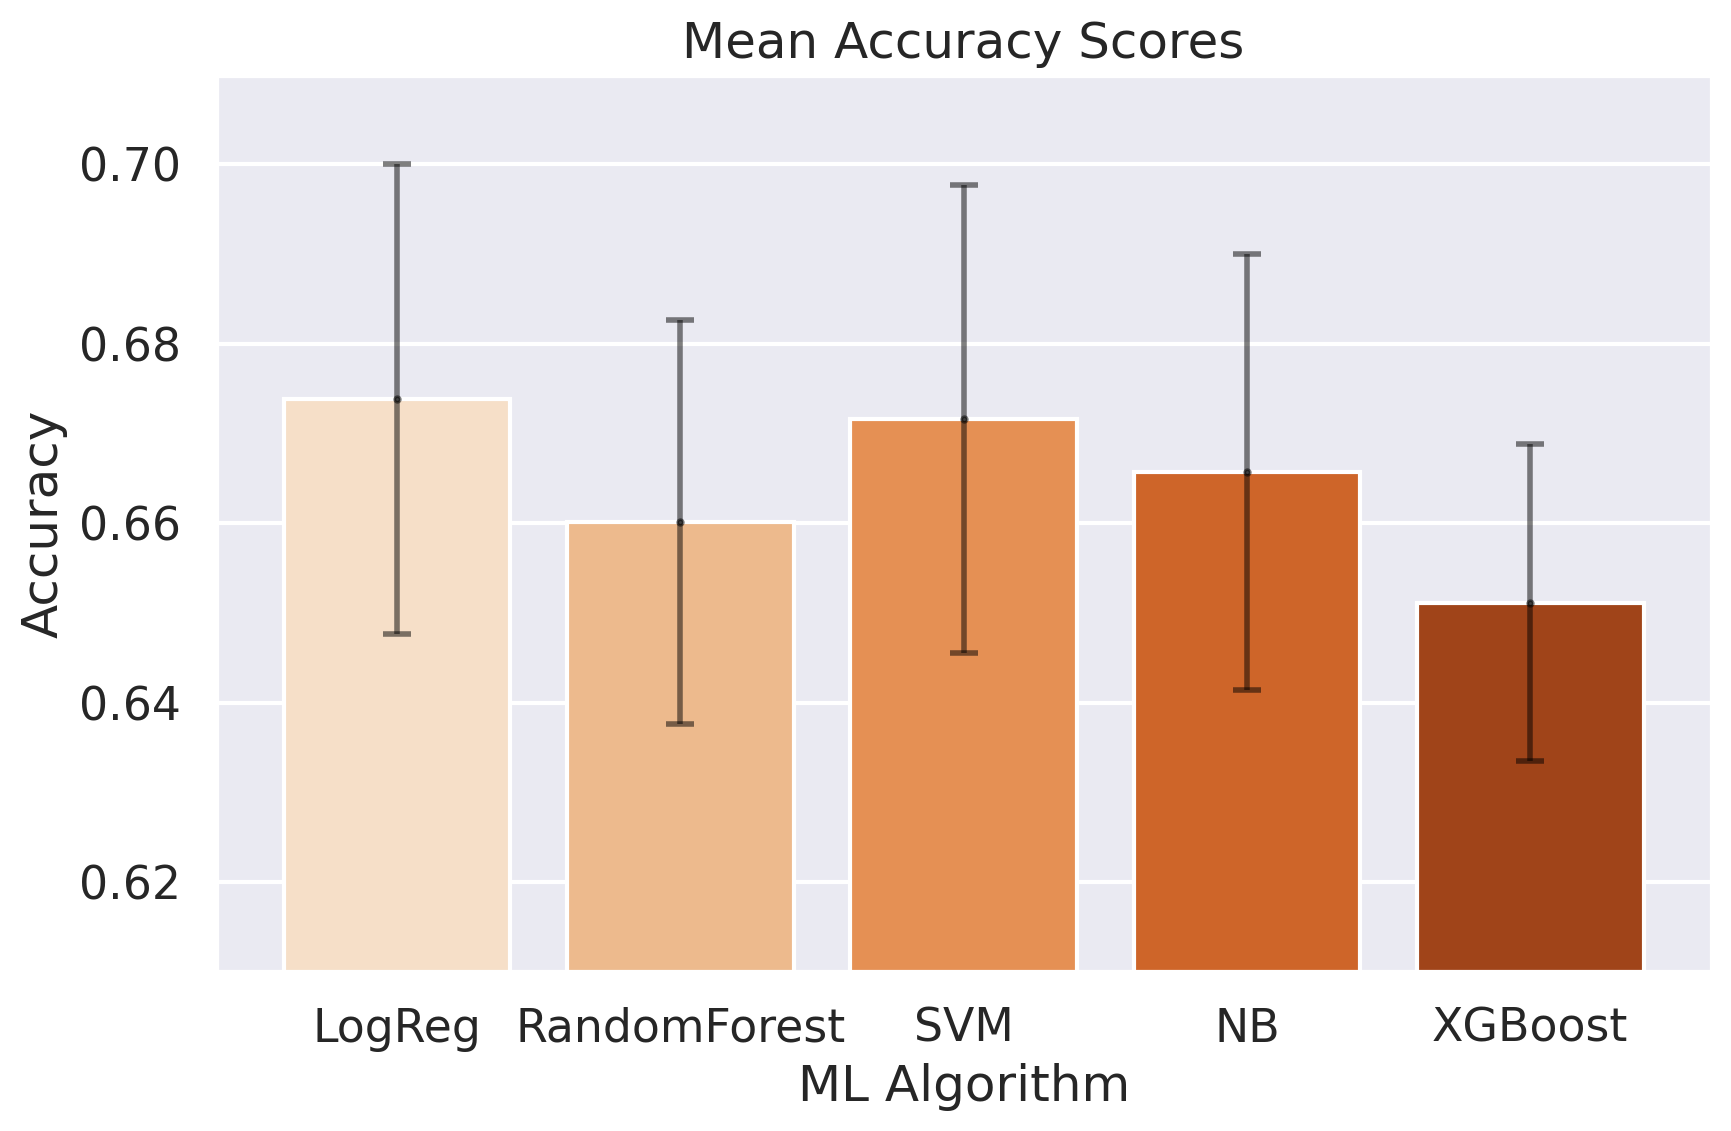

In [58]:
fig, ax = plt.subplots(figsize=(9, 6))

sns.barplot(x=['LogReg', 'RandomForest', 'SVM', 'NB', 'XGBoost'], 
            y='Accuracy', 
            data=results_adv_df,
            palette='Oranges')

ax.set_title('Mean Accuracy Scores')
ax.set_ylabel('Accuracy')
ax.set_xlabel('ML Algorithm')
#ax.set_xticklabels(results_adv_df.index, rotation=22.5)
ax.set_ylim(bottom=0.61, top=0.71)

ax.errorbar(x=['LR', 'RFC', 'SVM', 'NB', 'XGBoost'], 
            y='Accuracy',
            yerr='STD', 
            fmt='.', 
            color='Black', 
            elinewidth=2,
            capthick=2,
            alpha=0.5, 
            ms=4, 
            capsize=5,
            data=results_adv_df)

plt.tight_layout()
plt.savefig('../saves/images/mean_accuracy.png')
plt.show()

The model performs better using advanced statistics, although not by much (~3%). Undersampling games where the home team won also did not lead to improved performance. Can we improve it by using more recent data only? As we know, the playing styles change with time (for example, three point shooting is more important nowadays than ever). Reducing the dataset size could also be helpful to reflect that home court advantage has not been as meaningful in the past few seasons. On the other hand, it may not be enough data for the algorithm to pick up patterns and predict the outcome of games correctly.

In [373]:
#results_us_df.to_csv('../saves/eval/accuracy_regularstats_us.csv')
#results_us_adv_df.to_csv('../saves/eval/accuracy_advstats_us.csv')

In [125]:
#results_df.to_csv('../saves/eval/accuracy_regularstats.csv')
#results_adv_df.to_csv('../saves/eval/accuracy_advstats.csv')

## Reduced dataset size

In [220]:
# Select only the past 4 seasons
reduced_df = data[data['Season'] > 2017]
reduced_df.head(3)

,Season,H_win,ORtg_V,DRtg_V,TS%_V,TOV%_V,ORB%_V,DRB%_V,W%_V,ORtg_H,DRtg_H,TS%_H,TOV%_H,ORB%_H,DRB%_H,W%_H
6150,2018,1,112.6,110.0,0.574,12.9,24.5,78.6,0.621951,112.2,107.8,0.567,11.5,21.6,77.0,0.597561
6151,2018,1,110.3,107.0,0.545,11.7,26.0,78.2,0.597561,115.9,109.5,0.596,12.6,22.5,77.1,0.695122
6152,2018,0,113.8,105.2,0.583,12.0,20.8,80.3,0.731707,111.4,112.5,0.554,10.9,21.7,77.1,0.475610


In [230]:
y = reduced_df['H_win']
X = reduced_df.drop(['Season', 'H_win', 'W%_V', 'W%_H'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [231]:
print(scaled_X_train.shape)
print(scaled_X_test.shape)

(3449, 12)
(1150, 12)


## Logistic regression

In [232]:
lr = LogisticRegression()
lr.fit(scaled_X_train, y_train)
y_pred = lr.predict(scaled_X_test)

print('LR model performance: %.3f' % lr.score(scaled_X_test, y_test))
print(classification_report(y_test, y_pred))

LR model performance: 0.659
              precision    recall  f1-score   support

           0       0.64      0.53      0.58       508
           1       0.67      0.76      0.71       642

    accuracy                           0.66      1150
   macro avg       0.65      0.65      0.65      1150
weighted avg       0.66      0.66      0.65      1150



In [233]:
results_lr_reduced = cross_val_score(lr, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
print("Accuracy: %.3f (%.3f)" % (results_lr_reduced.mean(), results_lr_reduced.std()))

Accuracy: 0.637 (0.060)


In [234]:
params_grid_lr = {
    'penalty': ['l1', 'l2'],
    'tol': [0.0005, 0.001, 0.005, 0.01],
    'C': [1.0, 2, 3, 4, 5, 6],
    'solver': ['liblinear', 'saga']}

gs_lr = GridSearchCV(estimator=lr, 
                      param_grid=params_grid_lr,
                      cv=2,
                      n_jobs=-1)

# Fit GridSearch to the data
gs_lr.fit(scaled_X_train, y_train)

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/linea

GridSearchCV(cv=2, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1.0, 2, 3, 4, 5, 6], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga'],
                         'tol': [0.0005, 0.001, 0.005, 0.01]})

In [235]:
best_lr = gs_lr.best_estimator_

# Make fit the data
best_lr.fit(scaled_X_train, y_train)

# Make pred
y_pred_best_lr = best_lr.predict(scaled_X_test)

In [236]:
# Check performance
print("LR best model score: %.4f" % best_lr.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_best_lr))

LR best model score: 0.6557
              precision    recall  f1-score   support

           0       0.63      0.53      0.58       508
           1       0.67      0.76      0.71       642

    accuracy                           0.66      1150
   macro avg       0.65      0.64      0.64      1150
weighted avg       0.65      0.66      0.65      1150



In [237]:
results_lr_adv = cross_val_score(best_lr, scaled_X_test, y_test, cv=kfold, scoring='accuracy')
print("Accuracy: %.3f (%.3f)" % (results_lr_adv.mean(), results_lr_adv.std()))

Accuracy: 0.637 (0.061)


Reducing the dataset to just 4 seasons does not seem to improve the model's performance significantly.

## Selecting KBestFeatures

In [241]:
# ANOVA feature selection for numeric input and categorical output
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# define feature selection
fs = SelectKBest(score_func=f_classif, k=3)

# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

f_classif(X, y)

(10749, 3)


(array([424.63387689, 218.97701671, 385.59498766,  52.14537191,
          0.63352292,  40.34431057, 447.64308738, 422.31798709,
        383.17686932,  56.85760705,  10.15143963,  64.00485061]),
 array([1.45310058e-92, 4.59036191e-49, 2.24711839e-84, 5.50263054e-13,
        4.26083600e-01, 2.21530632e-10, 2.23771544e-97, 4.43871293e-92,
        7.24258095e-84, 5.06322160e-14, 1.44600872e-03, 1.36874297e-15]))

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train))
scaled_X_test = pd.DataFrame(scaler.fit_transform(X_test))

print(scaled_X_train.shape, '\n', scaled_X_test.shape)

(7524, 3) 
 (3225, 3)


In [243]:
lr = LogisticRegression(random_state=0)

# Fit the data 
lr.fit(scaled_X_train, y_train)

# Make predictions
y_pred = lr.predict(scaled_X_test)

# Check performance
print("LR model score: %.4f" % lr.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred))

LR model score: 0.6533
              precision    recall  f1-score   support

           0       0.63      0.50      0.56      1404
           1       0.67      0.77      0.72      1821

    accuracy                           0.65      3225
   macro avg       0.65      0.64      0.64      3225
weighted avg       0.65      0.65      0.65      3225



In [244]:
# Instantiate XGBClassifier
xgb = XGBClassifier(use_label_encoder=False)

# Fit the data
xgb.fit(scaled_X_train, y_train)

# Make predictions
y_pred_xgb = xgb.predict(scaled_X_test)

# Check performance
print("XGB model score: %.3f" % xgb.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_xgb))

[19:03:04] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB model score: 0.635
              precision    recall  f1-score   support

           0       0.59      0.52      0.55      1404
           1       0.66      0.72      0.69      1821

    accuracy                           0.64      3225
   macro avg       0.63      0.62      0.62      3225
weighted avg       0.63      0.64      0.63      3225



/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [245]:
# Instantiate SVM classifier
svc = SVC()

# Fit the data
svc.fit(scaled_X_train, y_train)

# Make predictions
y_pred_svc = svc.predict(scaled_X_test)

# Check performance
print("SVC model score: %.3f" % svc.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_svc))

SVC model score: 0.650
              precision    recall  f1-score   support

           0       0.63      0.48      0.55      1404
           1       0.66      0.78      0.72      1821

    accuracy                           0.65      3225
   macro avg       0.64      0.63      0.63      3225
weighted avg       0.65      0.65      0.64      3225



### Optimize model using reduced features

In [246]:
params_grid_lr = {
    'penalty': ['l1', 'l2'],
    'tol': [0.0005, 0.001, 0.005, 0.01],
    'C': [1.0, 2, 3, 4, 5, 6],
    'solver': ['liblinear', 'saga']}

gs_lr = GridSearchCV(estimator=lr, 
                      param_grid=params_grid_lr,
                      cv=2,
                      n_jobs=-1)

# Fit GridSearch to the data
gs_lr.fit(scaled_X_train, y_train)
gs_lr.best_params_

{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0005}

In [247]:
best_lr = gs_lr.best_estimator_

# Make fit the data
best_lr.fit(scaled_X_train, y_train)

# Make pred
y_pred_best_lr = best_lr.predict(scaled_X_test)

# Check performance
print("LR best model score: %.4f" % best_lr.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_best_lr))

LR best model score: 0.6536
              precision    recall  f1-score   support

           0       0.63      0.50      0.56      1404
           1       0.67      0.77      0.72      1821

    accuracy                           0.65      3225
   macro avg       0.65      0.64      0.64      3225
weighted avg       0.65      0.65      0.65      3225



In [248]:
# Parameter grid for svc model
params_grid_svc = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.75, 1, 1.25, 2],
    'gamma': ['scale', 'auto']}

In [249]:
# Perform GridSearch for SVM
gs_svc = GridSearchCV(estimator=svc, 
                      param_grid=params_grid_svc,
                      cv=2,
                      n_jobs=-1)

# Fit GridSearch to the data
gs_svc.fit(scaled_X_train, y_train)

gs_svc.best_params_

{'C': 1.25, 'gamma': 'scale', 'kernel': 'linear'}

In [250]:
# store best estimator
best_svc = gs_svc.best_estimator_

# Fit on the dataset 
best_svc.fit(scaled_X_train, y_train)
y_pred_best_svc = best_svc.predict(scaled_X_test)

# Check performance
print("SVC model score: %.3f" % best_svc.score(scaled_X_test, y_test))

print(classification_report(y_test, y_pred_best_svc))

SVC model score: 0.655
              precision    recall  f1-score   support

           0       0.63      0.49      0.55      1404
           1       0.67      0.78      0.72      1821

    accuracy                           0.65      3225
   macro avg       0.65      0.64      0.64      3225
weighted avg       0.65      0.65      0.65      3225



# Export best performing model

In the end, the best performing model was SVC using the advanced team statistics and without undersampling home team wins. This model will be exported using pickle.

In [63]:
# Export model using dill
filename = 'nba_game_prediction.pkl'
pickle.dump(gs_svc, open(filename, 'wb'))

In [64]:
loaded_model = pickle.load(open('nba_game_prediction.pkl', 'rb'))
result = loaded_model.score(scaled_X_test, y_test)
print(result)

0.6710077519379845


In [112]:
# Export scaler to use in app
filename = 'scaler.pkl'
pickle.dump(scaler, open(filename, 'wb'))